In [ ]:
def onebyone(mat_oco2,fh5):
    """
    Recibe la matriz de mediciones filtradas por processlist y el archivo h5 donde se va a escribir las mediciones
    Escribe las mediciones por latitud y longitud en el archivo h5
    """

    for ii,line in enumerate(mat_oco2):

        lat = line["/latitude"]
        lon = line["/longitude"]

        try:
            dset=fh5['%iN%iW' % (int(lat),int(lon))]
            n=dset.shape[0]
            dset.resize((n+1,))
            dset[n]=line
            fh5.flush()
        except:
            datalatlon=[line]
            try:
                dset=fh5.create_dataset('%iN%iW' % (int(lat),int(lon)),data=datalatlon,maxshape=(None,))

                fh5.flush()
            except:
                print 'nada works'


In [ ]:
def processlist(lista,h5filename):
    """
    Recibe una lista de archivos nc4 de oco2 para filtrarlos de acuerdo a latmin, latmax, lonmin y lonmax y el nombre del archivo h5 de salida
    Llama a onebyone
    """

    try:
        fh5=h5py.File(h5filename,'r+')
        print 'file exist'
    except:
        fh5=h5py.File(h5filename,'w')
        print 'new file'

    cont = 0
    for filename in lista:
        #print filename
        datos=h5py.File(filename,'r')
        lat = datos["/latitude"][()]
        lon = datos["/longitude"][()]
        xco2_qf = datos["/xco2_quality_flag"][()]
        cond_latlon = ((lat > latmin) & (lat < latmax) & (lon > lonmin) & (lon < lonmax) & (xco2_qf == 0))	### FILTRO PARA LATITUD, LONGITUD Y xco2_quality_flag = 0 (GOOD)
        #print filename,len(lat),len(lat[cond_latlon])
        if len(lat[cond_latlon]) > 0:          ### SOLO CUANDO AL APLICAR EL FILTRO SE OBTIENE AL MENOS UNA MEDICION
            mat_inter = np.empty(len(lat[cond_latlon]),dtype=oco2_co2_type)
            for name in oco2_co2_type.names[3:]:       ### NO CONSIDERA tepoch, lat y lon POR QUE NO ESTAN EN EL HDF DE oco2
                mat_inter[name] = datos[name][()][cond_latlon]
            mat_inter["tepoch"] = np.array([(dt.datetime(year=huh[0],month=huh[1],day=huh[2],hour=huh[3],minute=huh[4],second=huh[5],microsecond=huh[6]*1000) - to).total_seconds() for huh in mat_inter["/date"]])
            mat_inter["lat"] = mat_inter["/latitude"]
            mat_inter["lon"] = mat_inter["/longitude"]
            #print "mat_inter",mat_inter.shape
            if cont == 0:
                mat_oco2 = copy.copy(mat_inter)	### SE CREA LA MATRIZ DONDE SE CONCATENAN LOS DIFERENTES DIAS AL INICIO, CUANDO EL CONTADOR ES 0
            else:
                mat_oco2 = np.concatenate((mat_oco2,mat_inter),axis=0)	### SE CONCATENA LOS VALORES FILTRADOS DE CADA DIA DEL MES A LA MATRIZ mat_oco2
            cont = cont+len(lat[cond_latlon])
        else:
            continue

        datos.close()
    #print "Contador",cont
    print "mat_oco2",h5filename,mat_oco2.shape
    onebyone(mat_oco2,fh5)	### SE MANDA LLAMAR onebyone
    #zlevels=np.arange(20)
    #fh5.attrs.create('zlevels', zlevels, dtype=zlevels.dtype )
    fh5.close()	### CIERRA EL ARCHIVO h5 DONDE SE ESCRIBE



In [ ]:
import numpy as np
import h5py

# test para leer, filtrar y escribir
inname = "f:\\jupyter\\test2.h5"
outname = "f:\\jupyter\\testout.h5"

latpoint = 19.483781                               # latitud del punto de interes
lonpoint = -99.147                                 # longitud del punto de interes
gridsize = 0.14

datos=h5py.File(inname,'r')

grid_max_lat = latpoint + gridsize
grid_min_lat = latpoint - gridsize
grid_max_lon = lonpoint - gridsize
grid_min_lon = lonpoint + gridsize

gridname = '%iN%iW' % (int(latpoint),int(lonpoint))
lat = datos[gridname]["/latitude"]
lon = datos[gridname]["/longitude"]



gridcond = ((lat <= grid_max_lat) & (lat >= grid_min_lat) & (lon <= grid_min_lon) & (lon >= grid_max_lon))

#filterdata = datos[gridname][gridcond]

print(datos[gridname][gridcond].shape, datos[gridname].shape)

fh5=h5py.File(outname,'w')
dset=fh5.create_dataset(gridname,data=datos[gridname][gridcond],maxshape=(None,))
fh5.flush()

datos.close()
fh5.close()

In [ ]:
import numpy as np
import h5py
import glob

h5look = "F:\\CCA\\NASAGESDISC\\OCO3L2Lite\\mexico2\\mexico2_oco3_lite_202002.h5"
h5name = glob.glob(h5look)
datos = h5py.File(h5name[0],'r')
coordname = '19N-98W'

lat = datos[coordname]['lat'][()]                                # vector de latitud
lon = datos[coordname]['lon'][()]
xco2qf = datos[coordname]['/xco2_quality_flag'][()]
tid = datos[coordname]['/Sounding/target_id'][()] 
tname = datos[coordname]['/Sounding/target_name'][()]
tidstr = tid.astype('U')
tnamestr = tname.astype('U')
psurf = datos[coordname]['/Retrieval/psurf'][()]
mask = (xco2qf == 0) & (tidstr == 'fossil0036')

print(len(tname[mask]))
#print(psurf[mask])
print(lat.dtype, tid.dtype, tname.dtype)
print(lat.dtype, tidstr.dtype, tnamestr.dtype)
#print(tname[mask])
print(tnamestr[mask])
print(psurf[mask])
datos.close()
#print(h5name)

In [ ]:
import numpy as np
import h5py
import glob
import copy
import datetime as dt

datos = np.load('D:\\CCA\\PaperCO2\\altzxco2offset2.npz','r')

In [ ]:
print(datos['tepoch'].shape)
print(datos['xco2'].shape)
print(datos['yfit'].shape)

In [ ]:
a1 = datos['CO2_v9']['jd_ut']
a2 = datos['/xCO2/datexco2all']
np.array_equal(a1,a2)

In [ ]:
t = datos['tepoch']
xco2 = datos['xco2']
yfit = datos['yfit']
dias = np.arange(366)
cont = 0
t0 = dt.datetime.utcfromtimestamp(0.0)
for dia in dias:
    mask = np.logical_and(t < (1577836800+(86400*(dia+1))), t >= (1577836800+(86400*dia)))
    d = t[mask]
    x = xco2[mask]
    y = yfit[mask]
    xavg = np.average(x)
    yavg = np.average(y)
    try:
        print(d.shape,x.shape)
        datee = dt.datetime.utcfromtimestamp(d[0])
        yr = datee.year
        dy = datee.day
        mnt = datee.month
        hr = datee.hour
        mn = datee.minute
        epochymd = (dt.datetime(year=yr,month=mnt,day=dy) - t0).total_seconds()
        print(d[0], yr, mnt, dy,hr,mn, xavg,yavg)
        data_inter = [epochymd,yr,mnt,dy,hr,mn,xavg,yavg]
        cont = cont + 1
        try:
            data = np.vstack((data,data_inter))
        except:
            data = copy.copy(data_inter)
    except:
        print(d.shape,x.shape)
print(data)

In [ ]:
print(cont,data.shape)

In [ ]:
tepoch = datos['CO2_v9']['tepoch']
xco2 = datos['/xCO2/xCO2']

In [ ]:
for i,ele in enumerate(tepoch):
    dte = dt.datetime.utcfromtimestamp(ele)
    mnt = dte.month
    dy = dte.day
    hr = dte.hour
    mn = dte.minute
    x = xco2[i]
    dta_inter = [ele,mnt,dy,hr,mn,x]
    try:
        dta = np.vstack((dta,dta_inter))
    except:
        dta = copy.copy(dta_inter)
    

In [ ]:
print(dta.shape)
print(dta)

In [ ]:
tepoch = data[:,0].astype(int)
year = data[:,1].astype(int)
month = data[:,2].astype(int)
day = data[:,3].astype(int)
hour = data[:,4].astype(int)
minute = data[:,5].astype(int)
xco2avg = data[:,6]
yfitavg = data[:,7]

In [ ]:
print(month.shape,month)

In [ ]:
temp = np.array([tepoch[0],year[0],month[0],day[0],hour[0],minute[0],xco2avg[0]])
print(temp)

In [ ]:
#### Should I average whole days or select closest time?
### 86400 seconds in a day
### posix utc for 1/1/2020 = 1577836800
### dayoftheyear for 20202 = 157783600 + (86400 * n)

In [ ]:
np.savez('altzrefavgoff', tepoch=tepoch, year=year, month=month, day=day, hour=hour, minute=minute, xco2avg=xco2avg,yfitavg=yfitavg)

In [ ]:
datos.close()

In [4]:
import numpy as np
import h5py
import glob
import copy
import datetime as dt
import matplotlib.pyplot as plt

dset = np.load('D:\\CCA\\test.npz', 'r')

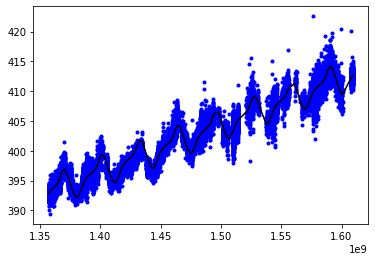

In [8]:
ax0=plt.subplot(1,1,1)
ax0.plot(dset['x'],dset['xco2'],'b.')
ax0.plot(dset['x'],dset['y'],'k-')
#ax0.plot(dset['x'],dset['yfit'],'r-')
plt.show()

In [4]:
m = dset['xco2avg']
for i, ele in enumerate(m):
    datarow = dt.datetime.utcfromtimestamp(dset['tepoch'][i]),dset['xco2avg'][i],dset['yfitavg'][i]
    if dset['tepoch'][i] >= 1577836800:
        print(datarow)

(datetime.datetime(2020, 1, 5, 0, 0), 409.6629787320601, 410.29931249219925)
(datetime.datetime(2020, 1, 6, 0, 0), 409.93042183698464, 410.3213315744965)
(datetime.datetime(2020, 1, 7, 0, 0), 409.9513744317623, 410.34080672020656)
(datetime.datetime(2020, 1, 8, 0, 0), 410.0178583925382, 410.360222133813)
(datetime.datetime(2020, 1, 9, 0, 0), 409.9709044210129, 410.38139474940596)
(datetime.datetime(2020, 1, 10, 0, 0), 410.2409613467451, 410.4006779122129)
(datetime.datetime(2020, 1, 11, 0, 0), 410.00823127125693, 410.4201721267337)
(datetime.datetime(2020, 1, 12, 0, 0), 409.93565628854066, 410.4386819941872)
(datetime.datetime(2020, 1, 13, 0, 0), 409.6292749497398, 410.45785262836256)
(datetime.datetime(2020, 1, 14, 0, 0), 409.7963471054638, 410.4774578928589)
(datetime.datetime(2020, 1, 15, 0, 0), 410.0309146817975, 410.49838367014075)
(datetime.datetime(2020, 1, 16, 0, 0), 411.05410787672736, 410.51913901729586)
(datetime.datetime(2020, 1, 17, 0, 0), 411.0594108371685, 410.5357393072

(datetime.datetime(2020, 9, 1, 0, 0), 409.870360504603, 409.96095007178315)
(datetime.datetime(2020, 9, 2, 0, 0), 409.0098844489881, 409.9252873034124)
(datetime.datetime(2020, 9, 3, 0, 0), 409.4837520925535, 409.8945039479201)
(datetime.datetime(2020, 9, 8, 0, 0), 410.1091290572658, 409.737415922139)
(datetime.datetime(2020, 9, 9, 0, 0), 408.7432305748588, 409.7093781008265)
(datetime.datetime(2020, 9, 14, 0, 0), 409.86992758512497, 409.5892187561781)
(datetime.datetime(2020, 9, 21, 0, 0), 408.82024804742207, 409.478628674929)
(datetime.datetime(2020, 9, 22, 0, 0), 409.3386177575837, 409.46926923653973)
(datetime.datetime(2020, 9, 23, 0, 0), 410.50465884432197, 409.46088789102953)
(datetime.datetime(2020, 9, 24, 0, 0), 406.98789167031646, 409.45475215876115)
(datetime.datetime(2020, 12, 10, 0, 0), 412.3335188975667, 412.1344523920557)
(datetime.datetime(2020, 12, 11, 0, 0), 412.24177432215464, 412.16778736569756)
(datetime.datetime(2020, 12, 12, 0, 0), 411.90041344668026, 412.19926257

In [3]:
dset.close()

In [1]:
import numpy as np
import h5py
import glob
import copy
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
datos = h5py.File("/home/mixtli/NASAGESDISC/OCO2/oco2test.nc4",'r')

In [3]:
datos.name

'/'

In [5]:
list(datos["/Retrieval"].keys())

['surface_type',
 'psurf',
 'SigmaB',
 'windspeed',
 'windspeed_apriori',
 'psurf_apriori',
 't700',
 'fs',
 'fs_rel',
 'tcwv',
 'tcwv_apriori',
 'tcwv_uncertainty',
 'xco2_raw',
 'dp',
 'dp_o2a',
 'dp_sco2',
 'dpfrac',
 's31',
 's32',
 'co2_grad_del',
 'dws',
 'eof3_3_rel',
 'snow_flag',
 'aod_dust',
 'aod_bc',
 'aod_oc',
 'aod_seasalt',
 'aod_sulfate',
 'aod_strataer',
 'aod_water',
 'aod_ice',
 'aod_total',
 'dust_height',
 'ice_height',
 'water_height',
 'h2o_scale',
 'deltaT',
 'albedo_o2a',
 'albedo_wco2',
 'albedo_sco2',
 'albedo_slope_o2a',
 'albedo_slope_wco2',
 'albedo_slope_sco2',
 'albedo_quad_o2a',
 'albedo_quad_wco2',
 'albedo_quad_sco2',
 'chi2_o2a',
 'chi2_wco2',
 'chi2_sco2',
 'rms_rel_o2a',
 'rms_rel_wco2',
 'rms_rel_sco2',
 'iterations',
 'diverging_steps']

In [6]:
datos.close()